In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

In [2]:
dataset = pd.read_csv('IBM_2006-01-01_to_2018-01-01.csv')
dataset = dataset.fillna(dataset.mean())

In [3]:
dataset.describe()

,Open,High,Low,Close,Volume
count,3020.000000,3020.000000,3020.000000,3020.000000,3.020000e+03
mean,145.515545,146.681738,144.471597,145.617278,5.773301e+06
std,37.548726,37.613446,37.471433,37.529387,3.192831e+06
min,72.740000,73.940000,69.500000,71.740000,2.542560e+05
25%,116.407500,117.765000,115.500000,116.525000,3.622681e+06
50%,149.605000,150.330000,148.425000,149.315000,4.928852e+06
75%,178.437500,179.762500,177.320000,178.685000,6.965014e+06
max,215.380000,215.900000,214.300000,215.800000,3.077428e+07


In [4]:
dataset.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
1,2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2,2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
3,2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
4,2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [5]:
dataset.tail()

,Date,Open,High,Low,Close,Volume,Name
3015,2017-12-22,151.82,153.00,151.50,152.50,2990583,IBM
3016,2017-12-26,152.51,153.86,152.50,152.83,2479017,IBM
3017,2017-12-27,152.95,153.18,152.61,153.13,2149257,IBM
3018,2017-12-28,153.20,154.12,153.20,154.04,2687624,IBM
3019,2017-12-29,154.17,154.72,153.42,153.42,3327087,IBM


In [6]:
training_set = dataset.iloc[0:2000, 1:2].values
training_set

array([[ 82.45],
       [ 82.2 ],
       [ 81.4 ],
       ...,
       [177.99],
       [176.88],
       [177.  ]])

In [7]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
sc_training_set = sc.fit_transform(training_set)
sc_training_set

array([[0.06807347],
       [0.06632081],
       [0.06071228],
       ...,
       [0.73787156],
       [0.73008974],
       [0.73093102]])

In [8]:
# Create a data structure with 120 timesteps and 1 output to predict every 30 days
X_train = []
y_train = []
for i in range(120, 2000, 30):
    X_train.append(sc_training_set[i-120:i,0])
    y_train.append(sc_training_set[i,0])

In [11]:
# convert them from lists to numpy arrays to train the estimator later
X_train = np.array(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.array(y_train)

In [12]:
# Import the following libraries to build RNN architecture
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [13]:
# Initialize RNN, 2 LSTM layers
estimator = Sequential()

estimator.add(LSTM(units=100,return_sequences=True,input_shape=(X_train.shape[1],1)))
estimator.add(Dropout(0.2))

# final LSTM layer
estimator.add(LSTM(units = 100))
estimator.add(Dropout(0.2))

# add output layer
estimator.add(Dense(units = 1))

In [14]:
# compiling the RNN
estimator.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [15]:
# Fit RNN to training set
estimator.fit(x=X_train, y=y_train, batch_size=32, epochs=3)

Epoch 1/3
63/63 [==============================] - 8s 132ms/step - loss: 0.2715
Epoch 2/3
63/63 [==============================] - 2s 34ms/step - loss: 0.1012
Epoch 3/3
63/63 [==============================] - 2s 39ms/step - loss: 0.0095


In [16]:
# making predictions with test set, the entire dataset
test_set = dataset.iloc[2500:,1:2].values
print(test_set.shape)

(520, 1)


In [17]:
sc_test_set = sc.fit_transform(test_set)
print(sc_test_set.shape)

(520, 1)


In [18]:
inputs = []
for i in range(120, 520, 30):
    inputs.append(sc_test_set[i-120:i, 0])
print(len(inputs))

14


In [19]:
# now, get test_set array with values that are divisible by 30 days for comparisons
test_set_30days = []
for i in range(120, 520, 30):
    test_set_30days.append(test_set[i, 0])
print((test_set_30days))

[153.0, 158.81, 159.0, 157.14, 159.8, 167.77, 181.45, 173.98, 150.62, 155.0, 141.75, 145.65, 154.18, 153.61]


In [20]:
inputs = np.array(inputs)
inputs = np.reshape(inputs, (inputs.shape[0], inputs.shape[1], 1))
print(inputs.shape)

(14, 120, 1)


In [21]:
prediction = estimator.predict(inputs)
prediction = sc.inverse_transform(prediction)

In [22]:
prediction

array([[159.93434],
       [163.72255],
       [174.99344],
       [169.92696],
       [167.7311 ],
       [180.21371],
       [190.14438],
       [191.7785 ],
       [173.14005],
       [166.38232],
       [159.36375],
       [155.04822],
       [165.72217],
       [166.26494]], dtype=float32)

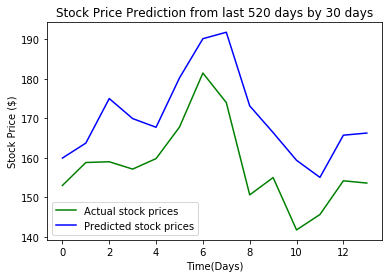

In [23]:
# Visualizing the results
plt.plot(test_set_30days, color = 'green', label = 'Actual stock prices')
plt.plot(prediction, color = 'blue', label = 'Predicted stock prices')
plt.title('Stock Price Prediction from last 520 days by 30 days')
plt.xlabel('Time(Days)')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.show()